In [44]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
import sklearn.preprocessing
from matplotlib import pyplot as plt
%matplotlib inline

## Copied from hw4.py (external file)

In [45]:
mnist = fetch_mldata('MNIST original')
data = mnist['data']
labels = mnist['target']

neg, pos = 0,8
train_idx = np.random.RandomState(0).permutation(np.where((labels[:60000] == neg) | (labels[:60000] == pos))[0])
test_idx = np.random.RandomState(0).permutation(np.where((labels[60000:] == neg) | (labels[60000:] == pos))[0])

train_data_size = 2000
train_data_unscaled = data[train_idx[:train_data_size], :].astype(float)
train_labels = (labels[train_idx[:train_data_size]] == pos)*2-1

test_data_size = 2000
test_data_unscaled = data[60000+test_idx[:test_data_size], :].astype(float)
test_labels = (labels[60000+test_idx[:test_data_size]] == pos)*2-1

# Preprocessing
train_data = sklearn.preprocessing.scale(train_data_unscaled, axis=0, with_std=False)
test_data = sklearn.preprocessing.scale(test_data_unscaled, axis=0, with_std=False)

## AdaBoost

In [5]:
def get_possible_threshold_values(train_data):
    ''' returns all threshold possible unique values for each pixel in the train_data'''
    thresholds_unique = []
    for feature in range(train_data.shape[1]): # runs over features
        thresholds_unique.append(np.unique(train_data[:,feature]))
    return thresholds_unique

In [6]:
def find_threshold(pixel_data, dist_weights, train_labels, thresh_unique):
    ''' Finds the best threshold, from the given possible threshold options
        return the best threshold, its error and direction (low or high)'''
    best_error = 1.0
    
    for thresh in thresh_unique: # iterate over all possible threshold options
        # error_low is measured on the hypothesis x_ij <= teta -> h(x)=1 and o.w. h(x)=-1
        error_low = float(sum((train_labels[pixel_data <= thresh] == -1)*dist_weights[pixel_data <= thresh])+sum((train_labels[pixel_data > thresh] == 1)*dist_weights[pixel_data > thresh]))
        
        if best_error >= min(error_low, 1-error_low): # chooses between the two hypothesis options (high, low) and compare to best
            best_direction = 'low' if error_low <= (1.0-error_low) else 'high'
            best_error = min(error_low, 1-error_low)
            best_teta = thresh    
    return best_teta, best_error, best_direction 


def hypothesis_learner(train_data, train_labels, dist_weights, thresh_unique):
    ''' finds the best hypothesis accross all pixels'''
    best_hypo = {'epsilon':1.0}
    for pixel in range(train_data.shape[1]): # choose the best pixel according to its error
        teta, err, direction = find_threshold(train_data[:, pixel], dist_weights, train_labels, thresh_unique[pixel])
        if best_hypo['epsilon'] >= err:
            best_hypo = {'epsilon': err, 'direction': direction, 'pixel': pixel, 'teta': teta}
    return best_hypo   # dictionary of best hypothesis parameters


In [7]:
def predict(hypo, sample):
    ''' retruns the classified sample based on the hypothesis'''
    value = sample[hypo['pixel']]
    if hypo['direction'] == 'low':
        if value <= hypo['teta']:return 1
        else: return -1
    elif value > hypo['teta']:return 1
    else: return -1
        

In [8]:
def update_distribution(dist_weights,hypo,train_data,train_labels):
    ''' Updates the Dt+1 according to error on Dt
        Returns the updated dist and alpha'''
    alfa = 0.5*log((1.0-hypo['epsilon'])/hypo['epsilon']) # alpha calculation
    correct = (np.apply_along_axis(lambda x: predict(hypo, x), 1, train_data)==train_labels)
    newdist = dist_weights*np.exp(-alfa*correct)
    Z = sum(newdist)
    newdist = newdist*1.0/Z
    return newdist, alfa

In [9]:
def Adaboost_predict(alfas,hypos,data, sign=True):
    '''given a data set predict the label:
        if sign, then return sign on the prediction'''
    M = np.array(map(lambda y: map(lambda x: predict(y,x), data),hypos)).T # returns a list of all predictions of all hypothesis
    if sign:
        return np.sign(M.dot(alfas)) #prediction is sign of weighted sum with alfas
    else:
        return M.dot(alfas)

In [10]:
def plot_err(T, err_list, names_list):
    ''' plot train and test errors over iterations'''
    for i in range(len(err_list)):
        plt.figure()
        plt.plot(range(T), err_list[i])
        plt.title(names_list[i]+' as a function of iteration')
        plt.ylabel('error')
        plt.xlabel('iteration')
        plt.legend([names_list[i]])
        plt.savefig('q5_'+names_list[i]+'_figure.png')

# MAIN

In [11]:
#Initialize first round
thresh_unique = get_possible_threshold_values(train_data) # get all possible threshold values (per pixel)
dist_weights = [1.0*np.ones(len(train_data))/len(train_data)] # initialize weights to uniform distribution
hypos = [] #learn best hypotesis
alfas=[]

T=10

for t in range(T):
    hypos.append(hypothesis_learner(train_data, train_labels, dist_weights[-1], thresh_unique))
    #hypos[-1]['epsilon'] = sum(dist_weights[-1]*(np.apply_along_axis(lambda x: predict(hypos[-1], x), 1, train_data)!=train_labels))
    dist,alfa = update_distribution(dist_weights[-1],hypos[-1],train_data,train_labels)
    dist_weights.append(dist) 
    alfas.append(alfa) 
    hypos[-1]['train_error'] = mean(Adaboost_predict(alfas,hypos,train_data)!=train_labels) # error on train data
    hypos[-1]['test_error'] = mean(Adaboost_predict(alfas,hypos,test_data)!=test_labels) # error on test data
    hypos[-1]['train_loss']= np.mean(np.exp(-1.0*Adaboost_predict(alfas,hypos,train_data, sign=False)*train_labels)) # loss function on train data
    hypos[-1]['test_loss']= np.mean(np.exp(-1.0*Adaboost_predict(alfas,hypos,test_data, sign=False)*test_labels)) # loss function on test data
    
    print 't = ', t

In [14]:
names_list = ['train_error', 'test_error', 'train_loss', 'test_loss']
err_list =[]
for name in names_list:
    err_list.append(map(lambda x: x[name], hypos))

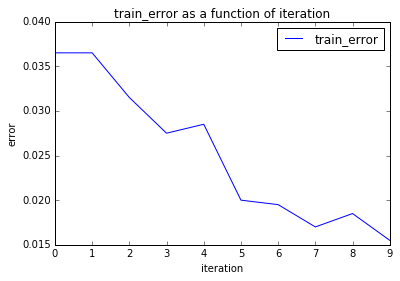

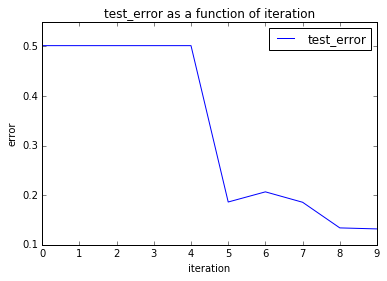

In [15]:
plot_err(T, err_list[:2], names_list[:2])

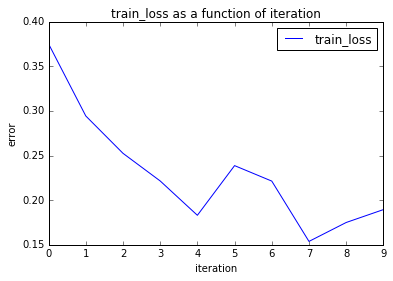

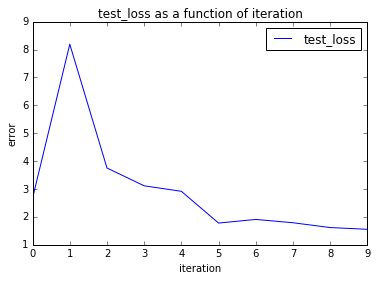

In [16]:
plot_err(T, err_list[-2:], names_list[-2:])